<a href="https://colab.research.google.com/github/urmilapol/urmilapolprojects/blob/master/plantvillage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [4]:
! cp /content/sample_data/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download abdallahalidev/plantvillage-dataset

100% 2.03G/2.04G [00:25<00:00, 35.9MB/s]
100% 2.04G/2.04G [00:25<00:00, 86.1MB/s]


In [10]:
!unzip /content/plantvillage-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [14]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [21]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plantvillage dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 162916 files belonging to 3 classes.


In [22]:
class_names = dataset.class_names
class_names

['color', 'grayscale', 'segmented']

In [23]:
len(dataset)

5092

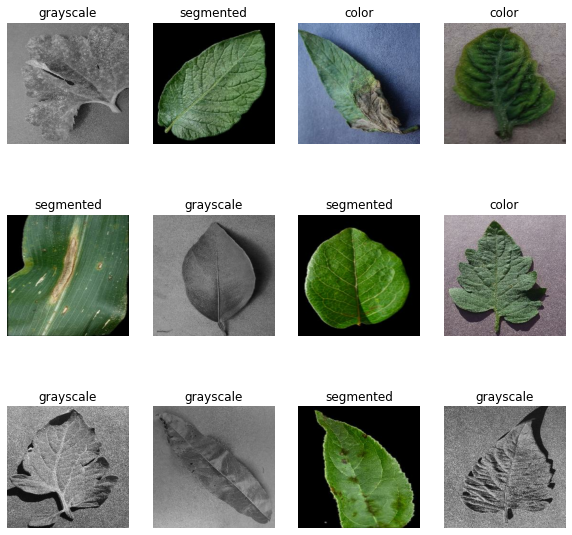

In [24]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [25]:
len(dataset)

5092

In [26]:
train_size = 0.8
len(dataset)*train_size
# dataset.take(10)

4073.6000000000004

In [27]:
train_ds = dataset.take(54)
len(train_ds)

54

In [28]:
test_ds = dataset.skip(54)
len(test_ds)


5038

In [29]:
val_size = 0.1
len(dataset)*val_size

509.20000000000005

In [30]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [31]:
test_ds = test_ds.skip(6)
len(test_ds)

5032

In [32]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split* ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [33]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [34]:
len(train_ds)

4073

In [35]:
len(val_ds)

509

In [36]:
len(test_ds)

510

In [37]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [39]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [40]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [3]:
model.summary()

NameError: ignored

In [2]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

NameError: ignored

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5


In [1]:
scores = model.evaluate(test_ds)

NameError: ignored